SMS Spam Detection 

Classifier Models Used : 

    Support vector classifier
    
    Naive Bayes
    
    Decision Tree
    
    Logistic Regression
    
    Random Forest
     
Comparison Between Models has been done using :
    
    Accuracy and F1 Score
    
    Confusion Matrices
    
    Misclassified samples from SVM

Import Data and Module

In [30]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
%matplotlib inline

In [31]:
df = pd.read_csv('./input/spam.csv', encoding='latin-1')
df = df.loc[:,['v1','v2']]
df.tail()

,v1,v2
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


Transforming first column `v1`, where `ham=0`, `spam=1`.

In [32]:
d={'spam':1,'ham':0}
df.v1 = list(map(lambda x:d[x],df.v1))

Conversion rom Text To Features

We have used tf-idf model on the text. The text will be 

1. lower: No captal appeared.
2. remove punctuation: No punctuation appeared.
3. stemmed: collect similar words (i.e. `words` will be transformed to `word`,etc.)

Then convert the cleaned text to tf-idf features (5000 features for an entry).

In [33]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

class stemmed_tfidf():
    def __init__(self,max_features=5000):
        self.ps = PorterStemmer()
        self.vc = TfidfVectorizer(analyzer='word',stop_words = 'english', max_features = max_features)
    def tfidf(self,ListStr):
        '''
        return: sklearn.feature_extraction.text.TfidfVectorizer
        '''
        table = self.vc.fit_transform([self.stem_string(s) for s in ListStr])
        return table
    def stem_string(self,s):
        '''
        s:str, e.g. s = "Get strings with string. With. Punctuation?"
        ps: stemmer from nltk module
        return: bag of words.e.g. 'get string with string with punctuat'
        '''    
        s = re.sub(r'[^\w\s]',' ',s)# remove punctuation.
        tokens = word_tokenize(s) 
        return ' '.join([self.ps.stem(w) for w in tokens])# e.g. 'desks'->'desk'

In [34]:
stf = stemmed_tfidf()
feature = stf.tfidf(df.v2) # this will be a sparse matrix of size (n,5000)

Prediction

In [35]:
print('%2.2f percent of data is spam: We have an inbalanced data set.'%round(100*sum(df.v1)/len(df),2))

13.41 percent of data is spam: We have an inbalanced data set.


In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(feature, df.v1, test_size=0.2, random_state=1)

In [8]:
Acc = {}
F1score = {}
confusion_mat={}
predictions = {}

Support vector classifier

In [9]:
val_scores = []
listc = np.linspace(0.5,3,num=4)
listgamma = np.linspace(0.5,3,num=4)
kernel = ['rbf','sigmoid']# 'poly' is doing bad here, let's save some time.
for v in kernel:
    for c in listc:
        for gamma in listgamma:
            svc = SVC(kernel=v, C=c, gamma=gamma,class_weight='balanced')
            scores = cross_val_score(svc, Xtrain, ytrain,scoring='f1')
            val_scores.append([np.mean(scores),v, c,gamma])

In [10]:
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0])

The best scores happens on: [['sigmoid' '1.33333333333' '0.5']] , where F1 = ['0.921963729333']


In [11]:
val_scores = []
listc = np.linspace(0.5,2,num=5)
listgamma = np.linspace(0.3,1,num=5)
for c in listc:
    for gamma in listgamma:
        svc = SVC(kernel='sigmoid', C=c, gamma=gamma,class_weight='balanced')
        scores = cross_val_score(svc, Xtrain, ytrain,scoring='f1')
        val_scores.append([np.mean(scores),v, c,gamma])
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0])

The best scores happens on: [['sigmoid' '1.25' '0.825']] , where F1 = ['0.924973193278']


In [12]:
name = 'SVM'
svc = SVC(kernel='sigmoid', C=1.25, gamma=0.825,class_weight='balanced')
svc.fit(Xtrain,ytrain)
pred = svc.predict(Xtest.toarray())
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

SVM: Accuracy=0.989, F1=0.957


2.2 Naive Bayes

In [13]:
GNB = GaussianNB()
GNB.fit(Xtrain.toarray(), ytrain)# Since our Xtrain is a sparse matrix, need to use .toarray() to convert it to dense one.
accuracy_score(ytest,GNB.predict(Xtest.toarray()))

0.86008968609865466

Using a better way, **multinominal Naive Bayes (MNB)**.

In [14]:
np.digitize([[0.1,0.22,0.33,0.8],[0.1,0.22,0.05,0.8]],bins = [.15,.25])

array([[0, 1, 2, 2],
       [0, 1, 0, 2]], dtype=int32)

In [15]:
bins = [.2,.4,.6,.8] # so every feature will end up 0,1,2,3,4
Xqtrain = np.digitize(Xtrain.toarray(),bins = bins)
Xqtest = np.digitize(Xtest.toarray(),bins = bins)

In [16]:
from sklearn.naive_bayes import MultinomialNB
val_scores = []
listalpha = np.linspace(0.01,1,num=20)
for i in listalpha:
    MNB = MultinomialNB(alpha=i)# alpha is Laplace smoothing parameter
    scores = cross_val_score(MNB, Xtrain, ytrain,scoring='f1')
    val_scores.append([np.mean(scores),i])
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0])

The best scores happens on: [[ 0.27052632]] , where F1 = [ 0.93487703]


In [17]:
name = 'MNB'
MNB = MultinomialNB(alpha=0.27052632)
MNB.fit(Xtrain,ytrain)
pred = MNB.predict(Xtest.toarray())
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

MNB: Accuracy=0.987, F1=0.949


This result is much better than using Gaussian NB.

Decision Tree

In [18]:
val_scores = []
for i in range(2,21):
    DT = DecisionTreeClassifier(min_samples_split=i, random_state=1,class_weight='balanced')
    scores = cross_val_score(DT, Xtrain, ytrain,scoring='f1')
    val_scores.append([np.mean(scores),i])
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0])

The best scores happens on: [[ 4.]] , where F1 = [ 0.83111103]


In [19]:
name = 'DT'
DT = DecisionTreeClassifier(min_samples_split=4, random_state=1,class_weight='balanced')
DT.fit(Xtrain,ytrain)
pred = DT.predict(Xtest.toarray())
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

DT: Accuracy=0.968, F1=0.878


Logistic Regression

In [20]:
list_C = np.linspace(0.1,3,num=20)
val_scores = []
for p in ('l1','l2'):
    for c in list_C:
        LR = LogisticRegression(penalty=p,C=c,class_weight='balanced')
        scores = cross_val_score(LR, Xtrain, ytrain,scoring='f1')
        val_scores.append([np.mean(scores),p,c])
val_scores = np.array(val_scores)
print('The best scores happens on:',val_scores[val_scores[:,0]==max(val_scores[:,0]),1:],
      ', where F1 =',val_scores[val_scores[:,0]==max(val_scores[:,0]),0])            

The best scores happens on: [['l2' '0.863157894737']] , where F1 = ['0.912843500453']


In [21]:
name = 'LR'
LR = LogisticRegression(penalty='l2',C=0.863157894737,class_weight='balanced')
LR.fit(Xtrain,ytrain)
pred = LR.predict(Xtest)
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

LR: Accuracy=0.987, F1=0.950


Random Forest

In [22]:
name = 'RF'
RF = RandomForestClassifier(n_estimators =80,class_weight ='balanced')
RF.fit(Xtrain,ytrain)
pred = RF.predict(Xtest)
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

RF: Accuracy=0.988, F1=0.952


Adaboost

In [23]:
name = 'AdaBoost'
Ada = AdaBoostClassifier(n_estimators=80, random_state=1)
Ada.fit(Xtrain,ytrain)
pred = Ada.predict(Xtest)
F1score[name]= f1_score(ytest,pred)
Acc[name] = accuracy_score(ytest,pred)
confusion_mat[name] = confusion_matrix(ytest,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

AdaBoost: Accuracy=0.984, F1=0.932


Comparison Between Models

In [24]:
'''import pickle
with open('spam_result.pickle', 'rb') as handle:
    b = pickle.load(handle)
Acc,F1score,confusion_mat,predictions = b[0],b[1],b[2],b[3]
'''

"import pickle\nwith open('spam_result.pickle', 'rb') as handle:\n    b = pickle.load(handle)\nAcc,F1score,confusion_mat,predictions = b[0],b[1],b[2],b[3]\n"

Accuracy and F1 Score

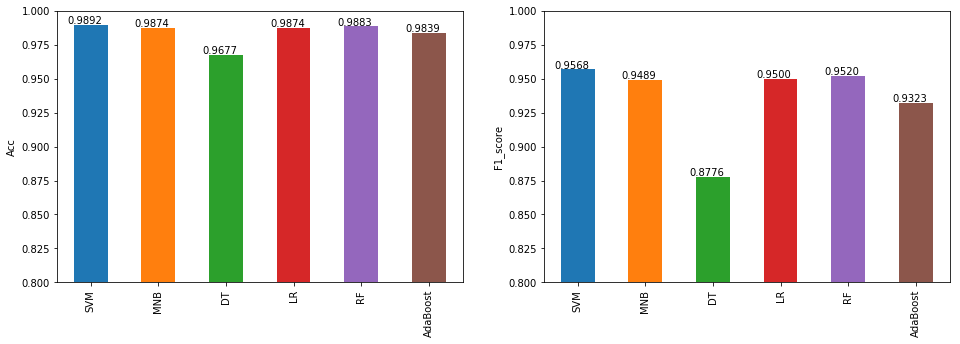

In [25]:
Results = pd.DataFrame([v for v in Acc.values()], columns = ['Acc'],
                    index = [k for k in Acc.keys()])
Results = Results.assign(F1_score=[v for v in F1score.values()])

fig = plt.figure(figsize=(16,5))
ylim = [[0.80,1],[0.8,1]]
x_offset = -0.35; y_offset = 0.001
for i,(a,yl) in enumerate(zip(list(Results.keys()),ylim)):
    plt.subplot(1,2,i+1)
    Results[a].plot(kind='bar')
    plt.ylabel(a); plt.ylim(yl)
    for p in plt.gca().patches:
        b = p.get_bbox()
        val = "{:1.4f}".format(b.y1 + b.y0)        
        plt.gca().annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))


Confusion Matrices

In [26]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout();plt.ylabel('True label');plt.xlabel('Predicted label')

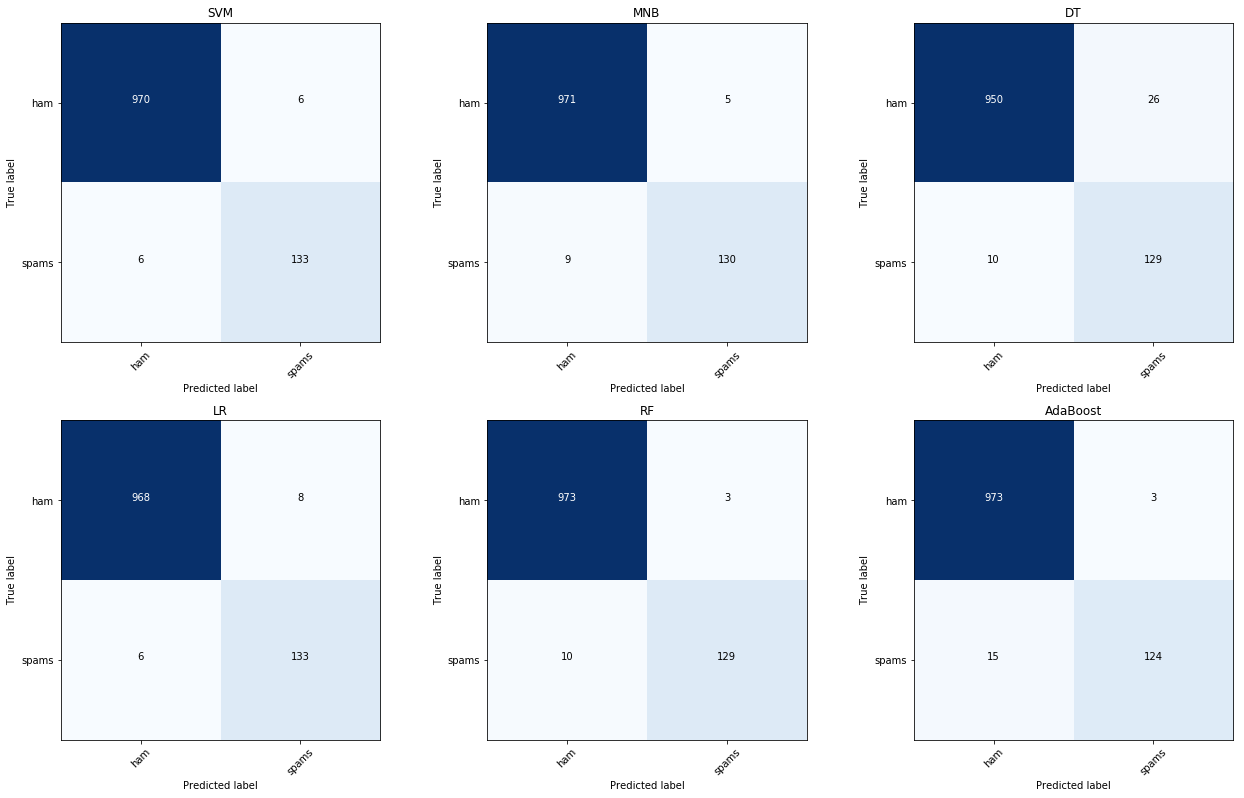

In [27]:
fig = plt.figure(figsize=(18,16))
i=1
for key,val in confusion_mat.items():
    plt.subplot(3,3,i);i+=1
    plot_confusion_matrix(val, classes=['ham','spams'], normalize=False,
                      title=key)

Misclassified samples from SVM

In [28]:
missclassified = np.nonzero(pred!=ytest)[0]
ind_miss = ytest.index[missclassified]
df.iloc[ind_miss,:]

,v1,v2
3493,1,You are being contacted by our dating service ...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...
689,1,<Forwarded from 448712404000>Please CALL 08712...
1662,1,Hi if ur lookin 4 saucy daytime fun wiv busty ...
1448,1,As a registered optin subscriber ur draw 4 å£1...
1499,1,"SMS. ac JSco: Energy is high, but u may not kn..."
5455,0,Wishing you a beautiful day. Each moment revea...
3417,1,LIFE has never been this much fun and great un...
2773,1,How come it takes so little time for a child w...
5,1,FreeMsg Hey there darling it's been 3 week's n...
